In [98]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [99]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Specifying device (CPU if GPU not compatible with CUDA)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [100]:
# Load dataset
 
dataset = pd.read_csv("labels_v2.csv")
dataset

,id,text,charles,amir,moindze,final
0,166,"Pourtant, avec la non prise en compte du vote ...",non dissident,non dissident,non dissident,non dissident
1,167,Supprimer toutes celles ne servant pas.,non dissident,dissident,dissident,dissident
2,168,suppression de l'ISF mal comprise/mal expliqué...,non dissident,non dissident,non dissident,non dissident
3,169,"Trop de ministres, trop de secrétaires d'état,...",dissident,non dissident,dissident,dissident
4,170,"Le système paraît trop lourd, coûteux et sourc...",non dissident,non dissident,non dissident,non dissident
...,...,...,...,...,...,...
95,261,les services publics disparaissent ou ouvrent ...,non dissident,non dissident,non dissident,non dissident
96,262,"TRop de fonctionnaires, notamment a Education ...",non dissident,non dissident,non dissident,non dissident
97,263,Pas de privilèges ni avantages post mandats (p...,non dissident,non dissident,non dissident,non dissident
98,264,"Au total, l'Etat pourrait économiser près de 2...",non dissident,non dissident,non dissident,non dissident


In [101]:
# Rename dataset columns

dataset =dataset.rename(columns = {"Category" : 'label'})
dataset

,id,text,charles,amir,moindze,final
0,166,"Pourtant, avec la non prise en compte du vote ...",non dissident,non dissident,non dissident,non dissident
1,167,Supprimer toutes celles ne servant pas.,non dissident,dissident,dissident,dissident
2,168,suppression de l'ISF mal comprise/mal expliqué...,non dissident,non dissident,non dissident,non dissident
3,169,"Trop de ministres, trop de secrétaires d'état,...",dissident,non dissident,dissident,dissident
4,170,"Le système paraît trop lourd, coûteux et sourc...",non dissident,non dissident,non dissident,non dissident
...,...,...,...,...,...,...
95,261,les services publics disparaissent ou ouvrent ...,non dissident,non dissident,non dissident,non dissident
96,262,"TRop de fonctionnaires, notamment a Education ...",non dissident,non dissident,non dissident,non dissident
97,263,Pas de privilèges ni avantages post mandats (p...,non dissident,non dissident,non dissident,non dissident
98,264,"Au total, l'Etat pourrait économiser près de 2...",non dissident,non dissident,non dissident,non dissident


In [102]:
# Delete columns and keep "final" and 'text' columns

dataset = dataset.drop(["id",'charles', "amir", "moindze"], axis = 1)

In [103]:
# Rename columns 

dataset =dataset.rename(columns = {"final" : 'label'})
dataset['label'] = dataset['label'].astype("category")
dataset.dtypes
dataset['label'] = dataset['label'].cat.codes
dataset.head()

,text,label
0,"Pourtant, avec la non prise en compte du vote ...",2
1,Supprimer toutes celles ne servant pas.,0
2,suppression de l'ISF mal comprise/mal expliqué...,2
3,"Trop de ministres, trop de secrétaires d'état,...",0
4,"Le système paraît trop lourd, coûteux et sourc...",2


In [104]:
# Split train dataset into train, val, and test

train_text, temp_text, train_labels, temp_labels = train_test_split(dataset['text'], dataset['label'],
                                                                    random_state = 2000,
                                                                    test_size = 0.3,
                                                                    stratify = dataset['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state = 2000,
                                                                test_size = 0.3,
                                                                stratify = temp_labels)
                                                                    

In [105]:
# import bert-based pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [106]:
# Bert tokenizer, we'll use it to incode a couple of sentences using the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [126]:
#Sample data

text = ['Ceci est un modele BERT', "nous allons utiliser ce modele pour notre classification"]

# encode text

sent_id = tokenizer.batch_encode_plus(text, padding = True, truncation = True)

# output
print(sent_id)

{'input_ids': [[101, 8292, 6895, 9765, 4895, 2944, 2063, 14324, 102, 0, 0, 0, 0, 0, 0], [101, 2053, 2271, 2035, 5644, 21183, 24411, 2121, 8292, 2944, 2063, 10364, 10289, 5579, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [108]:
'''
input_ds : contains the integer sequences of the input sentences. The integers 101 and 102 are special tokens.
We add them to both sequences, and 0 represents the padding token.

'attention mask' contains the 0's and 1's. It tells the model to pay attention to the tokens corresponding to the mask value of 1 and ignore the rest.
'''

"\ninput_ds : contains the integer sequences of the input sentences. The integers 101 and 102 are special tokens.\nWe add them to both sequences, and 0 represents the padding token.\n\n'attention mask' contains the 0's and 1's. It tells the model to pay attention to the tokens corresponding to the mask value of 1 and ignore the rest.\n"

<AxesSubplot:>

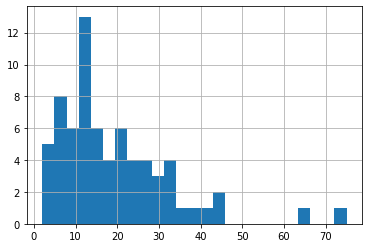

In [109]:
# Tokenize the sentences.

'''
With sentences of varying length, we'll use padding to make all the messages havethe same length
Before, we'll display the distribution of the sequence lengths in the train set to find the right padding length
'''
sequence_length = [len(i.split()) for i in train_text]

pd.Series(sequence_length).hist(bins = 25)

In [110]:
max_seq_len = 25

In [111]:
'''
Set 30 as the padding length
'''

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

C:\Users\amirb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [112]:
'''
Now we can convert sequences to tensors
'''

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


# Convert validation set sequences to tensors

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Convert test set sequences to tensors
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [113]:
'''
For train and val test, we'll create a dataloaders which will pass batches of train data
and validation data as input to the model during the training phase
'''

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [114]:
'''
Before fine tuning, we'll freeze all the layers to prevent updating of model weights during fine tuning. However, we don't 
have to execute the code below if we wish to fine-tune the pre-trained weights of the BERT model.
'''

for param in bert.parameters():
    param.requires_grad = False

In [115]:
'''
Define architecture model
'''

class BERT_Arch(nn.Module):

  def __init__(self, bert):
    super(BERT_Arch, self).__init__()

    self.bert = bert 
      
    # dropout layer
    self.dropout = nn.Dropout(0.1)
      
    # relu activation function
    self.relu =  nn.ReLU()

    # dense layer 1
    self.fc1 = nn.Linear(768,512)
    
    # dense layer 2 (Output layer)
    self.fc2 = nn.Linear(512,2)

    #softmax activation function
    self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x


In [116]:
'''
Now we can pass the pre-trained BERT to our architecture
'''

model = BERT_Arch(bert)

#Push the model to GPU
model = model.to(device)

In [117]:
'''
Once the model in our architecture, we can use the AdamW optimizer
'''

# optimizer from hugging face
from transformers import AdamW

# Optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5) 

C:\Users\amirb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [118]:
'''
As our dataset is imbalanced (with majority of 'non dissident' labels) we'll first compute class 
weights for the labels in the train set and then pass the weights to the loss function in order to 
include the class imbalance in our model.
'''

from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_wts)


Class Weights: [2.33333333 3.88888889 0.43209877]


In [119]:
'''
Now we convert our list of class to a tensor
'''
weights = torch.tensor(class_wts , dtype = torch.float)

# push to GPU
weights = weights.to(device)

# Define the loss function
cross_entropy = nn.NLLLoss(weight = weights)

# Training epochs 
epochs = 10

In [123]:
'''
Now we have to define a couple of functions to train and evaluate the model
'''

# Train the model

def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # For loop to iterate over batches
    for step, batch in enumerate(train_dataloader):
        # Progess update after every 50 batches

        if step % 50 == 0 and not step == 0:
            print("Batch {:> 5,} of {: > 5,}".format(step, len(train_dataloader)))

        # Push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Clear previously calculated gradients
        model.zero_grad()

        # get model predictions for current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [124]:
'''
To evaluate the model, our function will use the validation set data
'''

# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [125]:
'''
After evaluating the model, we can fine-tuning it
'''

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_losses)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


NotImplementedError: Module [BERT_Arch] is missing the required "forward" function

In [ ]:
# Make Predictions

# load weights of the best model

path = "saved_weights.pt" #
model.load_state_dict(torch.load(path))

# Get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# Model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_weights.pt'